# LUNA16 as test set

In [1]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import wilcoxon
from statannotations.Annotator import Annotator
import sys
sys.path.append('/home/local/VANDERBILT/litz/github/MASILab/lobe_seg')
from luna16_preprocess import get_kfolds

In [2]:
metric_dir = "/home/local/VANDERBILT/litz/data/luna16/metrics"
johof_folds = glob.glob(os.path.join(metric_dir, "johof_norm*"))
lsm_folds = glob.glob(os.path.join(metric_dir, "lsm_*"))
johof_folds = sorted(johof_folds)
lsm_folds = sorted(lsm_folds)
totalseg_path = "/home/local/VANDERBILT/litz/data/luna16/metrics/TS_luna16.csv"
finetune_path = "/home/local/VANDERBILT/litz/github/MASILab/lobe_seg/models/0911_TS/test_luna16.csv"


In [13]:
totalseg_df = pd.read_csv(totalseg_path)
finetune_df = pd.read_csv(finetune_path)

In [11]:
johof_df = pd.read_csv(johof_folds[0])
# johof_df["fold"] = int(johof_folds[0][-5])
# johof_df["path"] = fold_paths
for i, johof_fold in enumerate(johof_folds):
    if i > 0:
        johof_fold_df = pd.read_csv(johof_fold)
        johof_df = pd.concat([johof_df, johof_fold_df], ignore_index=True)
# johof_df.drop(columns=['Unnamed: 0'], inplace=True)

lsm_df = pd.read_csv(lsm_folds[0])
# lsm_df["fold"] = int(lsm_folds[0][-5])
for i, lsm_fold in enumerate(lsm_folds):
    if i > 0:
        lsm_fold_df = pd.read_csv(lsm_fold)
        lsm_df = pd.concat([lsm_df, lsm_fold_df], ignore_index=True)
lsm_df.drop(columns=['Unnamed: 0'], inplace=True)

In [16]:
def lobe_map(x):
    if x=='0': return 'LUL'
    if x=='1': return 'LLL'
    if x=='2': return 'RUL'
    if x=='3': return 'RML'
    if x=='4': return 'RLL'

johof_df['id'] = johof_df.index
lsm_df['id'] = lsm_df.index
finetune_df['id'] = finetune_df.index
totalseg_df['id'] = totalseg_df.index

johof_long = pd.melt(johof_df, id_vars=['id'], value_vars=['0', '1', '2', '3', '4'])
johof_long['model'] = 'Hof.'
lsm_long = pd.melt(lsm_df, id_vars=['id'], value_vars=['0', '1', '2', '3', '4'])
lsm_long['model'] = 'LSM'
finetune_long = pd.melt(finetune_df, id_vars=['id'], value_vars=['0', '1', '2', '3', '4'])
finetune_long['model'] = 'Proposed'
totalseg_long = pd.melt(totalseg_df, id_vars=['id'], value_vars=['0', '1', '2', '3', '4'])
totalseg_long['model']= 'TotalSeg'

all_df = pd.concat([johof_long, lsm_long, finetune_long], ignore_index=True)
# # convert lobe numbers to names
all_df = all_df.rename(columns={'variable':'Lobe', 'value': 'Dice score'})
all_df['Lobe'] = all_df['Lobe'].apply(lobe_map)
all_df

,id,Lobe,Dice score,model
0,0,LUL,0.908171,Hof.
1,1,LUL,0.949562,Hof.
2,2,LUL,0.936145,Hof.
3,3,LUL,0.904868,Hof.
4,4,LUL,0.956015,Hof.
...,...,...,...,...
700,42,RLL,0.969071,Proposed
701,43,RLL,0.929131,Proposed
702,44,RLL,0.968837,Proposed
703,45,RLL,0.914733,Proposed


In [17]:
print(all_df.groupby(['model']).mean())
print(all_df.groupby(['model']).std())
print(all_df.groupby(['model', 'Lobe']).mean())
print(all_df.groupby(['model', 'Lobe']).std())

            id  Dice score
model                     
Hof.      23.0    0.899635
LSM       23.0    0.898225
Proposed  23.0    0.927827
                 id  Dice score
model                          
Hof.      13.593613    0.104568
LSM       13.593613    0.106558
Proposed  13.593613    0.097633
                 id  Dice score
model    Lobe                  
Hof.     LLL   23.0    0.933251
         LUL   23.0    0.925332
         RLL   23.0    0.938300
         RML   23.0    0.792376
         RUL   23.0    0.908914
LSM      LLL   23.0    0.934729
         LUL   23.0    0.922632
         RLL   23.0    0.938958
         RML   23.0    0.783988
         RUL   23.0    0.910816
Proposed LLL   23.0    0.960069
         LUL   23.0    0.967602
         RLL   23.0    0.956991
         RML   23.0    0.829015
         RUL   23.0    0.925455
                      id  Dice score
model    Lobe                       
Hof.     LLL   13.711309    0.024245
         LUL   13.711309    0.028438
         RLL 

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

LSM vs. Proposed: Mann-Whitney-Wilcoxon test two-sided, P_val:2.213e-05 U_stat=5.430e+02
Hof. vs. Proposed: Mann-Whitney-Wilcoxon test two-sided, P_val:6.745e-05 U_stat=5.770e+02


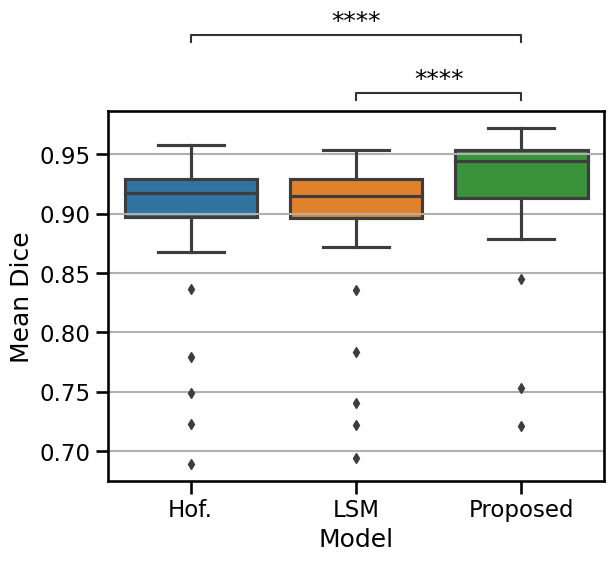

In [19]:
mean_df = all_df.groupby(["id", "model"], as_index=False).agg({"Dice score": "mean"})
# mean_3dunet = mean_df[mean_df["model"]=="3DUnet"]["Dice score"].values
mean_hof = mean_df[mean_df["model"]=="Hof."]["Dice score"].values
mean_lsm = mean_df[mean_df["model"]=="LSM"]["Dice score"].values
# mean_lsm = mean_df[mean_df["model"]=="TotalSeg"]["Dice score"].values
mean_finetune = mean_df[mean_df["model"]=="Proposed"]["Dice score"].values

# w, p = wilcoxon(mean_3dunet, mean_hof, alternative="greater")
# print(f'3dunet, hof: {w}, {p}')
# w, p = wilcoxon(mean_3dunet, mean_lsm, alternative="greater")
# print(f'3dunet, lsm: {w}, {p}')
# w, p = wilcoxon(mean_lsm, mean_hof, alternative="two-sided")
# print(f'lsm, hof: {w}, {p}')


# plot stat significance
# order = ['Hof.', 'LSM','3DUnet', 'AL']
order = ['Hof.', 'LSM', 'Proposed']
pairs = [('Proposed', 'Hof.'), ('Proposed', 'LSM')]

f, ax = plt.subplots()
bplot = sns.boxplot(x="model", y="Dice score", data=mean_df, orient="v", order=order, hue_order=order)
bplot.set(xlabel="Model", ylabel="Mean Dice")
ax.yaxis.grid(True)
annotator = Annotator(bplot, pairs, data=mean_df, x="model", y="Dice score", order=order)
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside', verbose=2)
annotator.apply_test()
bplot, test_results = annotator.annotate()

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

LLL_LSM vs. LLL_Proposed: Mann-Whitney-Wilcoxon test two-sided, P_val:4.416e-10 U_stat=2.790e+02
RUL_LSM vs. RUL_Proposed: Mann-Whitney-Wilcoxon test two-sided, P_val:6.052e-03 U_stat=7.410e+02
RML_LSM vs. RML_Proposed: Mann-Whitney-Wilcoxon test two-sided, P_val:2.086e-03 U_stat=6.970e+02
RLL_LSM vs. RLL_Proposed: Mann-Whitney-Wilcoxon test two-sided, P_val:4.503e-04 U_stat=6.400e+02
LUL_LSM vs. LUL_Proposed: Mann-Whitney-Wilcoxon test two-sided, P_val:4.728e-14 U_stat=1.070e+02
RUL_Hof. vs. RUL_Proposed: Mann-Whitney-Wilcoxon test two-sided, P_val:3.265e-03 U_stat=7.150e+02
RML_Hof. vs. RML_Proposed: Mann-Whitney-Wilcoxon test two-sided, P_val:9.494e-03 U_stat=7.610e+02
RLL_Hof. vs. RLL_Proposed: Mann-Whitney-Wilcoxon test two-sided, P_val:2.175e-04 U_stat=6.150e+02
LLL_Hof. vs. LLL_Proposed: Mann-Whitney-

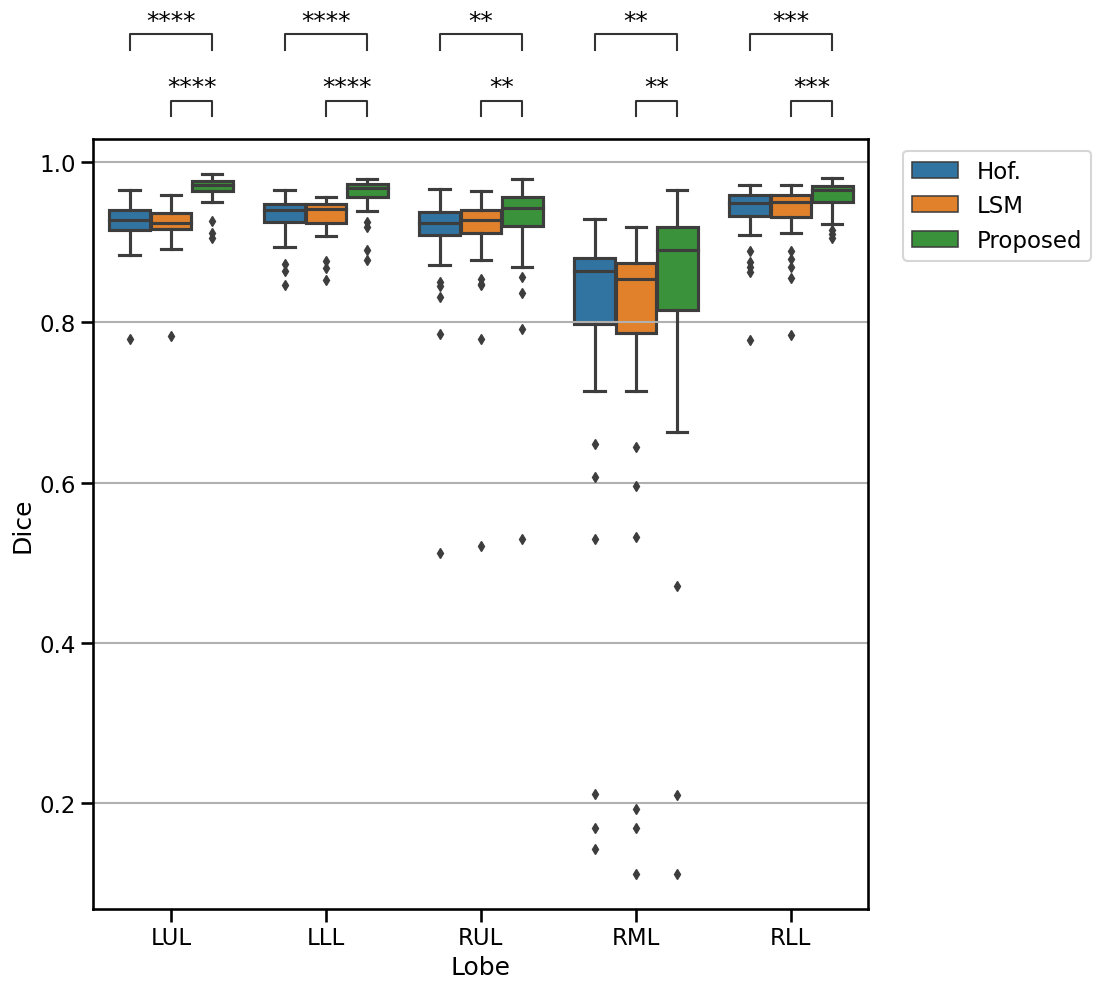

In [20]:
all_sorted = all_df.sort_values(["id", "model", "Lobe"])
# print(all_sorted[:30])
# all_3dunet = all_sorted[all_sorted["model"]=="3DUnet"]["Dice score"].values
all_hof = all_sorted[all_sorted["model"]=="Hof."]["Dice score"].values
all_lsm = all_sorted[all_sorted["model"]=="LSM"]["Dice score"].values

# w, p = wilcoxon(all_3dunet, all_hof, alternative="greater")
# print(f'3dunet, hof: {w}, {p}')
# w, p = wilcoxon(all_3dunet, all_lsm, alternative="greater")
# print(f'3dunet, lsm: {w}, {p}')
# w, p = wilcoxon(all_hof, all_lsm, alternative="two-sided")
# print(f'lsm, hof: {w}, {p}')

hue = "model"
# hue_order = ['Hof.', 'LSM', '3DUnet', 'AL']
hue_order = ['Hof.', 'LSM', 'Proposed']
order = ['LUL', 'LLL', 'RUL', 'RML', 'RLL']
f, ax = plt.subplots(figsize=(10, 10))
bplot = sns.boxplot(data=all_sorted, x="Lobe", y="Dice score", 
                    order=order, hue="model", hue_order=hue_order)
bplot.set(xlabel="Lobe", ylabel="Dice")
plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
ax.yaxis.grid(True)
# plot stat significance
pairs=[(('LUL', 'Proposed'), ('LUL', 'Hof.')),
       (('LUL', 'Proposed'), ('LUL', 'LSM')),
       (('LLL', 'Proposed'), ('LLL', 'Hof.')),
       (('LLL', 'Proposed'), ('LLL', 'LSM')),
       (('RUL', 'Proposed'), ('RUL', 'Hof.')),
       (('RUL', 'Proposed'), ('RUL', 'LSM')),
       (('RML', 'Proposed'), ('RML', 'Hof.')),
       (('RML', 'Proposed'), ('RML', 'LSM')),
       (('RLL', 'Proposed'), ('RLL', 'Hof.')),
       (('RLL', 'Proposed'), ('RLL', 'LSM')),
      ]
annotator = Annotator(bplot, pairs, data=all_sorted, x="Lobe", y="Dice score", 
                      order=order, hue=hue, hue_order=hue_order)
annotator.configure(test='Mann-Whitney', text_format='star', loc="outside", verbose=2)
annotator.apply_test()
bplot, test_results = annotator.annotate()

In [23]:
import math
table2 = all_df.groupby(['model'], as_index=False).agg(mean=("Dice score", "mean"), count=("Dice score", "count"), std=("Dice score","std"))
# print(table2)
ci95_hi = []
ci95_lo = []

for i in table2.index:
    *_, m, c, s = table2.loc[i]
    ci95_hi.append(m + 1.96*s/math.sqrt(c))
    ci95_lo.append(m - 1.96*s/math.sqrt(c))

table2['ci95_lo'] = ci95_lo
table2['ci95_hi'] = ci95_hi

table2 = table2.drop(['count', 'std'], axis=1)
table2.sort_values(by=['model'])

,model,mean,ci95_lo,ci95_hi
0,Hof.,0.899635,0.886265,0.913004
1,LSM,0.898225,0.884600,0.911849
2,Proposed,0.927827,0.915344,0.940310


In [24]:
import math
table2 = all_df.groupby(['model', 'Lobe'], as_index=False).agg(mean=("Dice score", "mean"), count=("Dice score", "count"), std=("Dice score","std"))
# print(table2)
ci95_hi = []
ci95_lo = []

for i in table2.index:
    *_, m, c, s = table2.loc[i]
    ci95_hi.append(m + 1.96*s/math.sqrt(c))
    ci95_lo.append(m - 1.96*s/math.sqrt(c))

table2['ci95_lo'] = ci95_lo
table2['ci95_hi'] = ci95_hi

table2 = table2.drop(['count', 'std'], axis=1)
table2.sort_values(by=['model'])

,model,Lobe,mean,ci95_lo,ci95_hi
0,Hof.,LLL,0.933251,0.926320,0.940183
1,Hof.,LUL,0.925332,0.917202,0.933462
2,Hof.,RLL,0.938300,0.928251,0.948349
3,Hof.,RML,0.792376,0.740409,0.844343
4,Hof.,RUL,0.908914,0.889207,0.928622
5,LSM,LLL,0.934729,0.928221,0.941236
6,LSM,LUL,0.922632,0.915236,0.930029
7,LSM,RLL,0.938958,0.929068,0.948847
8,LSM,RML,0.783988,0.731548,0.836428
9,LSM,RUL,0.910816,0.891487,0.930146
